# Knapsack Problem - Evolutionary Algorithm

This file contains an implementation of an **Evolutionary Algorithm** to solve the **0/1 Knapsack Problem**. The algorithm evolves a population of potential solutions over several generations, using selection, crossover, and mutation operations to maximize the value of items in the knapsack without exceeding its weight capacity.

### How It Works
The algorithm starts with a all-zero population of binary individuals (bitstrings) representing item selections. Over multiple generations, the fittest individuals are selected and modified to evolve better solutions. The evolution process includes:
- **Fitness Evaluation**: Individuals are scored based on the total value of selected items while respecting the weight constraint.
- **Tournament Selection**: The best solution among randomly chosen candidates is selected.
- **Uniform Crossover**: Two parents exchange genes to form new offspring.
- **Mutation**: Random changes are introduced to promote diversity.
- **Repair Mechanism**: Infeasible solutions (overweight knapsacks) are adjusted by randomly removing items until they become valid.

### Hyperparameters
The hyperparameters define the behavior of the evolutionary process and are dynamically adjusted based on the problem size. Here is a breakdown of the key hyperparameters and why they are set as they are:

- **Population Size (`population_size`)**:
  - Initially set to `bits * 10` (10 times the number of items).
  - Reduced for larger problems to balance computation time.
  - For `bits >= 100`, set to `bits * 2`.
  - For `bits >= 500`, set to `bits * 0.7`.
  - For `bits >= 1000`, set to `bits * 0.5`.
  - **Rationale**: Larger populations provide diversity, but excessive sizes slow down execution. The scaling balances these aspects.

- **Number of Generations (`generations`)**:
  - Initially set to `bits`.
  - For `bits >= 100`, reduced to `bits * 0.5`.
  - For `bits >= 500`, reduced to `bits * 0.3`.
  - For `bits >= 1000`, reduced to `bits * 0.2`.
  - **Rationale**: Larger problem sizes require fewer generations per item, as selection pressure and crossover quickly refine good solutions. For example for the problem with `len(items) = 100`, 50 generations are enough. However, for `len(items) = 1000`, 500 generations are too many.

- **Tournament Size (`tournament_size`)**:
  - Set to `6`.
  - **Rationale**: Balances selective pressure; higher values lead to premature convergence, while lower values reduce selection efficiency.

- **Crossover Rate (`crossover_rate`)**:
  - Set to `0.9` (90% chance of crossover).
  - **Rationale**: Encourages frequent recombination of good traits while still allowing some individuals to pass on genes unchanged.

- **Mutation Rate (`mutation_rate`)**:
  - Set to `0.6`, modified by `mutation_const = 1 / bits`.
  - **Rationale**: Ensures that smaller problems' individuals' genes have a same chance of mutation as larger problems.

### Functions

#### **Data Handling**
- `load_knapsack_data(filename)`: Loads the problem instance from a file.

#### **Evolutionary Algorithm**
- `initialize_population(size, items, W)`: Creates a all-zero initial population.
- `fitness(individual, items, W)`: Evaluates how good a solution is.
- `evaluate_population(population, items, W)`: Ranks individuals and calculates best/average fitness.
- `generate_new_population(population, items, W, params)`: Produces a new generation using selection, crossover, and mutation.

#### **Genetic Operators**
- `tournament_selection(population, items, W, k)`: Selects the best individual from a random subset.
- `uniform_crossover(parent1, parent2, crossover_rate)`: Produces two offspring by randomly mixing genes.
- `mutate(individual, mutation_rate)`: Randomly flips bits with a given probability.
- `repair_individual(ind, items, capacity)`: Ensures individuals do not exceed knapsack capacity.

#### **Visualization & Output**
- `plot(title, best_fitness, avg_fitness, params)`: Plots the best and average fitness over generations.
- `line_fw_print(strs, widths, flush=True, char='|')`: Prints formatted progress updates.
- `run_evolution(params, test_data)`: Main function to run the algorithm and print progress.

### Running the Code

To run the algorithm on a test file:
```sh
python3 solution.py
```

Then, enter the path to test file when prompted:
```
Enter the path to the test file:
```

Example Output:
```
Running 100.txt test...
|Generation   ||Population   ||Best Fit   ||Avg. Fit   ||Time sec.|
+-------------++-------------++-----------++-----------++---------+
|80/80:       ||200          ||9147       ||7731       ||1.390    |

```

A plot will be generated after all computations, showing the progression of fitness scores over generations.


## Results
The algorithm was tested on various problem instances with different sizes and characteristics. Here are the results from running the evolutionary algorithm on the provided test files (input_1000.txt, input_100.txt).:


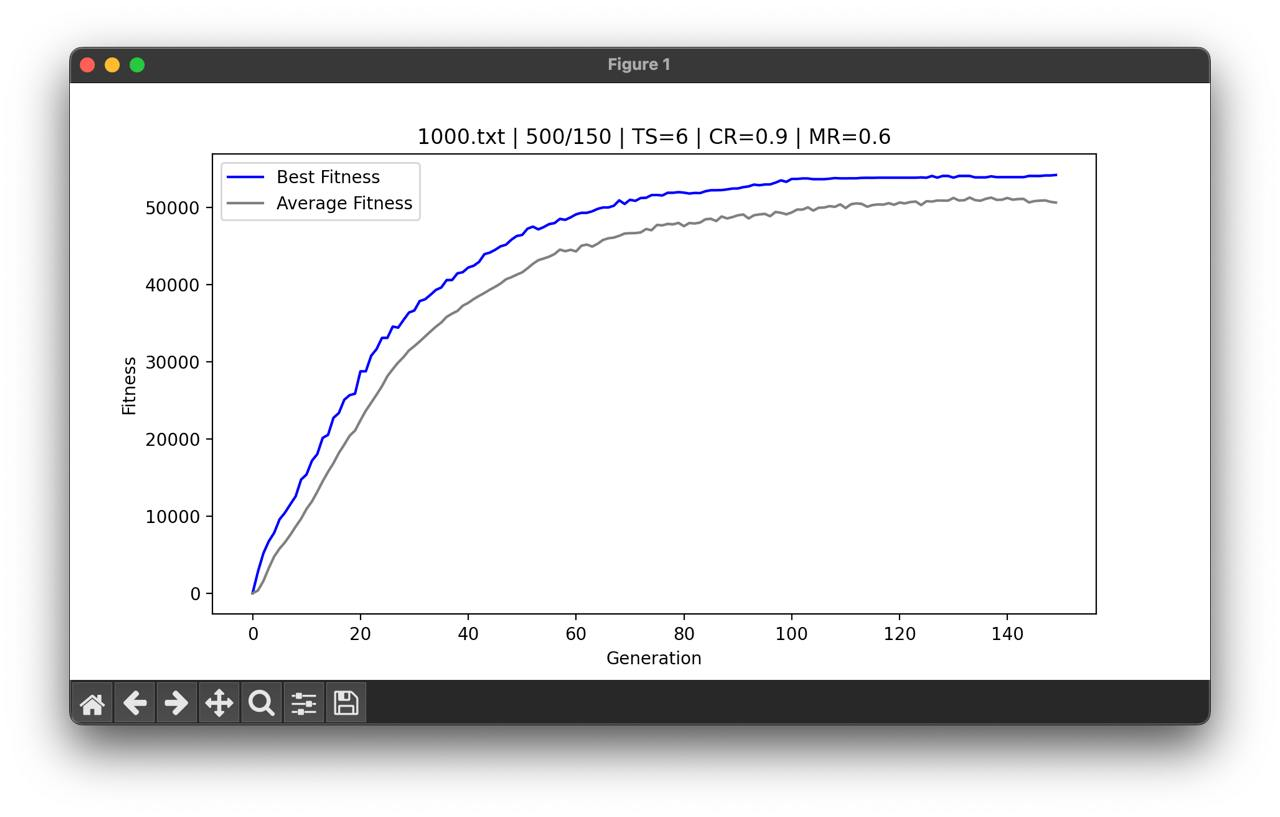


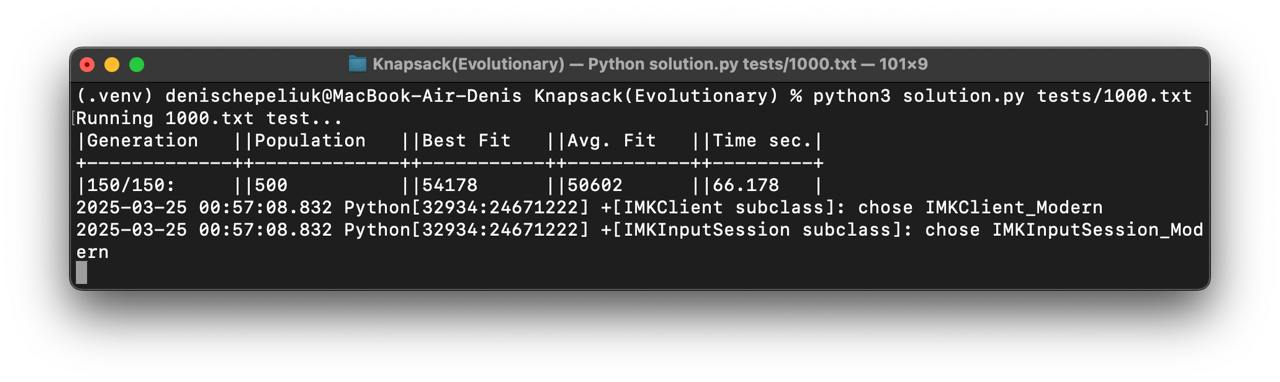


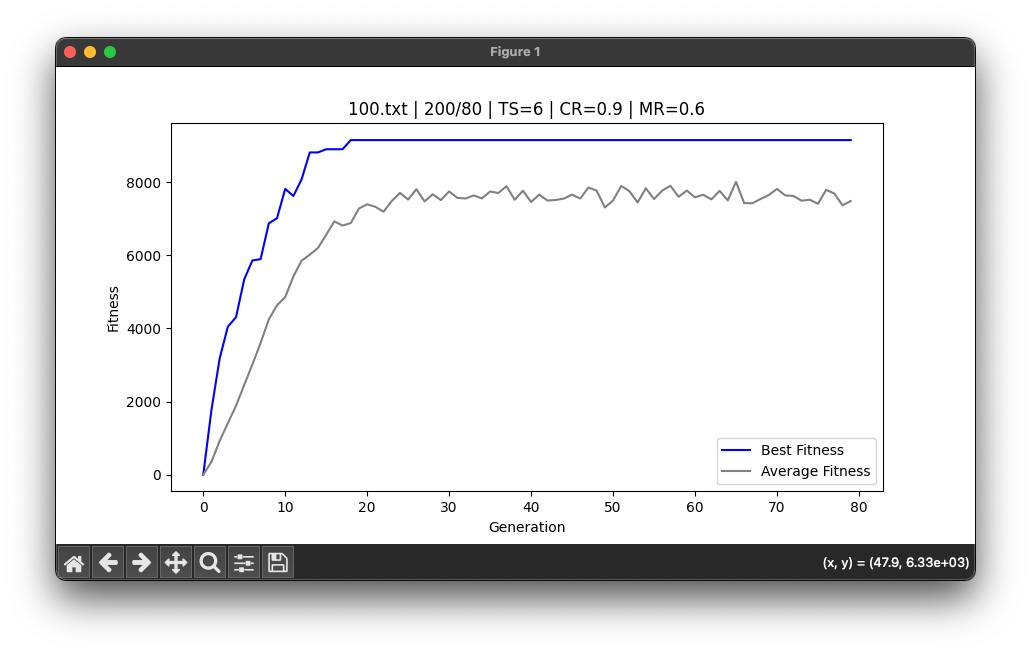


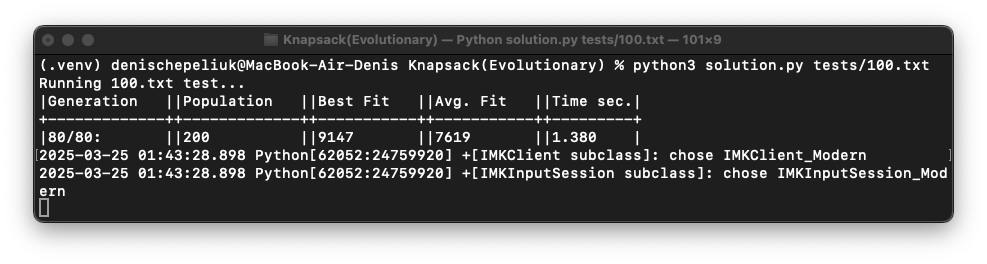

In [10]:
import base64
import IPython.display as display
from IPython.display import HTML

def embed_image(filename):
    with open(filename, "rb") as f:
        image_data = f.read()
    encoded = base64.b64encode(image_data).decode("utf-8")
    return f'<img src="data:image/png;base64,{encoded}" width="600"/>'

display.display(HTML(embed_image("input_1000.jpg")))
display.display(HTML(embed_image("input_1000(terminal).jpg")))
display.display(HTML(embed_image("input_100.jpg")))
display.display(HTML(embed_image("input_100(terminal).jpg")))


## Code
The full code for the evolutionary algorithm is provided below:

In [ ]:
import random
import matplotlib.pyplot as plt
import time

def load_knapsack_data(filename):
    # Load the knapsack data from the file
    # Return the number of items, the maximum weight of the knapsack, and the list of items (price, weight)
    with open(filename, "r") as f:
        n, W = map(int, f.readline().split())
        items = [tuple(map(int, line.split())) for line in f]
    return n, W, items

def fitness(individual, items, W):
    # Calculate the total price of the items in the knapsack
    total_price = 0
    for (c, _), bit in zip(items, individual):
        total_price += c * bit
    # Calculate the total weight of the items in the knapsack
    total_weight = 0
    for (_, w), bit in zip(items, individual):
        total_weight += w * bit
    # Return the total price if items fit in the knapsack, otherwise return 0
    return total_price if total_weight <= W else 0

def initialize_population(size, items, W):
    # Initialize the population with random individuals
    # Each individual is generated by randomly selecting items until the weight limit is reached
    population = []
    for _ in range(size):
        individual = [0] * len(items)
        population.append(individual)
    return population

def repair_individual(ind, items, capacity):
    # Remove random items from the individual until the total weight is less than or equal to the capacity
    # Helps to ensure that the individual is a valid solution to the knapsack problem
    total_weight = sum(items[i][1] for i in range(len(ind)) if ind[i] == 1)
    while total_weight > capacity:
        if sum(ind) == 0:
            break
        remove_idx = random.choice([i for i in range(len(ind)) if ind[i] == 1])
        ind[remove_idx] = 0
        total_weight -= items[remove_idx][1]

def tournament_selection(population, items, W, k):
    # Choose k individuals from the population at random
    # Return the individual with the highest fitness
    selected = random.sample(population, k)
    return max(selected, key=lambda ind: fitness(ind, items, W))

def uniform_crossover(parent1, parent2, crossover_rate):
    # Perform uniform crossover between parent1 and parent2
    if random.random() < crossover_rate:
        return [bit1 if random.random() < 0.5 else bit2 for bit1, bit2 in zip(parent1, parent2)], [bit1 if random.random() < 0.5 else bit2 for bit1, bit2 in zip(parent2, parent1)]
    return parent1, parent2

def mutate(individual, mutation_rate):
    # Modify the individual directly
    for i in range(len(individual)):
        if random.random() < mutation_rate:
            individual[i] = 1 - individual[i]

def plot(title, best_fitness, avg_fitness, params, live=False):
    plt.plot(best_fitness, label="Best Fitness", color='blue')
    plt.plot(avg_fitness, label="Average Fitness", color='gray')
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title(
        f"{title} | {params['population_size']}/{params['generations']} | TS={params['tournament_size']} | CR={params['crossover_rate']} | MR={params['mutation_rate']}")
    plt.legend()
    plt.show()

def initialize_parameters(bits):
    # Initialize the parameters based on input data size
    population_size = bits * 10
    generations = bits
    if bits >= 100:
        population_size = bits * 2
        generations = int(bits * 0.8)
    if bits >= 500:
        population_size = int(bits * 0.7)
        generations = int(bits * 0.3)
    if bits >= 1000:
        population_size = int(bits * 0.5)
        generations = int(bits * 0.2)

    return {
        "population_size": population_size,
        "generations": generations,
        "tournament_size": 6,
        "crossover_rate": 0.9,
        "mutation_rate": 0.6,
        "mutation_const": 1 / bits
    }

def evaluate_population(population, items, W):
    # Evaluate the fitness of each individual in the population
    # Return the population sorted by fitness, the best fitness, and the avg
    population = sorted(population, key=lambda ind: fitness(ind, items, W), reverse=True)
    best = fitness(population[0], items, W)
    avg = sum(fitness(ind, items, W) for ind in population) / len(population)
    return population, best, avg

def generate_new_population(population, items, W, params):
    # Generate a new population using tournament selection, crossover, and mutation
    # Each new individual is generated by selecting two parents, performing crossover, and mutation
    # At each step the new individual is repaired to ensure it is a valid solution
    new_population = []
    while len(new_population) < params["population_size"]:
        parent1 = tournament_selection(population, items, W, params["tournament_size"])
        parent2 = tournament_selection(population, items, W, params["tournament_size"])
        child1, child2 = uniform_crossover(parent1, parent2, params["crossover_rate"])

        repair_individual(child1, items, W)
        repair_individual(child2, items, W)

        mutation_rate = params["mutation_rate"] * params["mutation_const"]
        mutate(child1, mutation_rate)
        mutate(child2, mutation_rate)

        repair_individual(child1, items, W)
        repair_individual(child2, items, W)

        new_population += [child1, child2]

    return new_population[:params["population_size"]]

def line_fw_print(strs, widths, flush=True, char='|'):
    line = "".join(char + str(s).ljust(w) + char for s, w in zip(strs, widths))
    print("\r" + line, end="", flush=flush)
    if not flush:
        print()

widths = [13, 13, 11, 11, 9]
def run_evolution(params, test_data):
    n, W, items = test_data
    best_fitness, avg_fitness = [], []
    start_time = time.time()
    gens = params["generations"]
    pop_size = params["population_size"]

    population = initialize_population(pop_size, items, W)


    # print(f"Generation | Population | Best Fit | Avg. Fit | Time sec.")
    line_fw_print(["Generation", "Population", "Best Fit", "Avg. Fit", "Time sec."], widths, flush=False)
    line_fw_print(["-" * w for w in widths], widths, flush=False, char='+')
    line_fw_print([f"{0}/{gens}:", pop_size, 0, 0, f"{0:.3f}"], widths)

    for gen in range(gens):
        population, best, avg = evaluate_population(population, items, W)
        best_fitness.append(best)
        avg_fitness.append(avg)

        if (gen + 1) % 10 == 0:
            cur_time = time.time()
            line_fw_print([ f"{gen + 1}/{gens}:", pop_size, best, int(avg), f"{cur_time - start_time:.3f}"], widths)

        population = generate_new_population(population, items, W, params)

    print()

    return best_fitness, avg_fitness

    # best_solution = max(population, key=lambda ind: fitness(ind, items, W))
    # return best_solution, fitness(best_solution, items, W)

if __name__ == "__main__":
    filename = input("Enter the path to the test file: ")
    print(f"Running {filename.split('/')[-1]} test...")

    # Load the knapsack data
    n, W, items = load_knapsack_data(filename)
    test = (n, W, items)

    # Initialize the parameters suited for the test data
    params = initialize_parameters(n)

    # Run the evolutionary algorithm
    start_time = time.time()
    best_fitness, avg_fitness = run_evolution(params, test)
    end_time = time.time()

    plot(filename.split('/')[-1], best_fitness, avg_fitness, params)